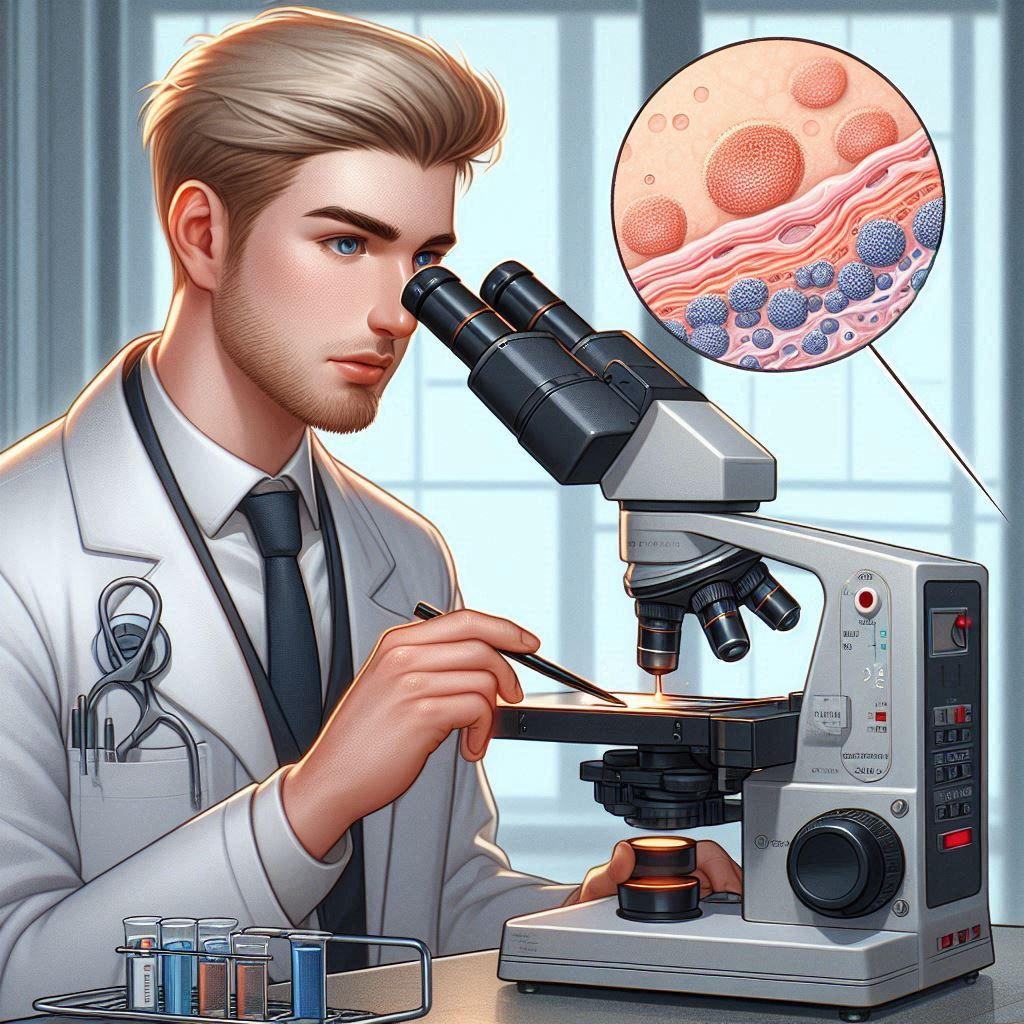
AI Generated Photo

This notebook demonstrates the process of fine-tuning the GPT-2 model using domain-specific data (skin cancer-related articles) fetched from PubMed.

It consists of the following steps:

1. Fetching articles from PubMed.

2. Preprocessing the dataset.

3. Fine-tuning GPT-2 using the Hugging Face transformers library.

4. Generating responses based on a user query with the fine-tuned GPT-2 model.

In [11]:
!pip install biopython

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#f0b0b0; overflow:hidden"><b>🟠 Fetching PubMed Articles Related to Skin Cancer 🟠</b></div>

In this section, we use the NCBI Entrez API via Biopython's Bio package to fetch abstracts related to skin cancer from PubMed. The fetched abstracts are saved to a file, which will be used for fine-tuning GPT-2.

In [12]:
# Import Libraries
from Bio import Entrez
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

# NCBI API settings
Entrez.email = "mirtahmid@gmail.com"  # Required by NCBI to use the API

# Search PubMed for skin cancer-related articles
def fetch_pubmed_articles(query="skin cancer", max_results=100):
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results)
    record = Entrez.read(handle)
    handle.close()

    ids = record['IdList']  # List of article IDs
    print(f"Found {len(ids)} articles.")

    articles = []

    for pmid in ids:
        time.sleep(0.5)  # To avoid overwhelming the API
        try:
            # Fetch article details
            handle = Entrez.efetch(db="pubmed", id=pmid, rettype="abstract", retmode="text")
            abstract = handle.read()
            handle.close()

            if abstract:
                articles.append(abstract.strip())
        except Exception as e:
            print(f"Error fetching article {pmid}: {e}")
            continue

    return articles

# Fetch the articles
articles = fetch_pubmed_articles(max_results=50)

# Save the articles to a text file
with open("pubmed_skin_cancer_articles.txt", "w") as f:
    for article in articles:
        f.write(article + "\n\n")

print("Fetched articles saved to 'pubmed_skin_cancer_articles.txt'")

Found 50 articles.
Fetched articles saved to 'pubmed_skin_cancer_articles.txt'


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#f0b0b0; overflow:hidden"><b>🟠Fine-Tune GPT-2 Using Hugging Face's Transformers 🟠</b></div>

Now, let's move on to fine-tuning GPT-2 using Hugging Face's transformers. Use the articles fetched in the previous step as the training data.

In [13]:
!pip install transformers datasets

In [14]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Tokenize the dataset
def load_dataset(file_path, block_size=128):
    """
    Load the dataset and tokenize it for GPT-2
    """
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size,
    )
    return dataset

# Data collator for dynamic padding
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # GPT-2 uses causal language modeling, not masked language modeling (MLM)
)

# Load the custom dataset (skin cancer-related PubMed abstracts)
dataset = load_dataset("pubmed_skin_cancer_articles.txt")

# Fine-tuning setup using Trainer API
training_args = TrainingArguments(
    output_dir="./fine_tuned_gpt2",
    overwrite_output_dir=True,
    num_train_epochs=3,  # Adjust epochs depending on dataset size
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
)

# Trainer API for fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

# Start fine-tuning
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2")

print("Fine-tuning complete. Model saved to './fine_tuned_gpt2'")

Step,Training Loss


Fine-tuning complete. Model saved to './fine_tuned_gpt2'


After Authorizing and pressing the code from (https://wandb.ai/authorize)

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#f0b0b0; overflow:hidden"><b>🟠Generate Responses Using the Fine-Tuned GPT-2🟠</b></div>

Once the fine-tuning process is done, you can use the fine-tuned model to generate domain-specific text (in this case, medical text related to skin cancer).

In [15]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the fine-tuned model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("./fine_tuned_gpt2")
model = GPT2LMHeadModel.from_pretrained("./fine_tuned_gpt2")

# Function to generate a response from the fine-tuned model
def generate_finetuned_response(prompt, max_length=200, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors='pt', max_length=512, truncation=True)

    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            max_length=max_length,
            temperature=temperature,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example: Generate a response to a medical query
prompt = "What are the symptoms of skin cancer?"
response = generate_finetuned_response(prompt)
print("Generated Response:", response)

Generated Response: What are the symptoms of skin cancer?
Skin cancer is a rare skin disease that can be treated with chemotherapy, radiation therapy, and skin-based treatments. The most common types of cancer are melanoma, psoriasis, 
dermatitis, skin psoriatica, breast cancer, prostate cancer and breast  illness. Skin cancer can also be diagnosed by  diagnosing skin lesions, which can include skin  skin cancers, melanomas, or herpes. Skin cancers can cause skin irritation, rash, irritation of the skin,  and skin rash.
The most commonly diagnosed skin conditions are psorsiasis and dermatosis. Dermatoses can (1) cause irritation and irritation to the surrounding skin and  (2) can result in skin infections. Psorosis can occur in the most common skin types, including psorectal, vulvar, hypospadias, dermatitis and psoral pulmonary


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:140%; font-family:Pacifico; background-color:#f0b0b0; overflow:hidden"><b>🟠Final Thoughts and Considerations🟠</b></div>

**Dataset Size:** The performance of fine-tuned GPT-2 depends on the size of the dataset. More domain-specific articles will lead to better fine-tuning. You can fetch more than 100 articles for a more robust fine-tuning process.

**Training Time:** Fine-tuning GPT-2 can take a significant amount of time, especially with larger datasets. Using a GPU will speed up this process.

**Model Customization:** This process can be adapted to any domain by changing the query used to fetch PubMed articles or using another relevant dataset.

**Applications:** Fine-tuned models like this one can be used in healthcare applications where generating medical information (with proper validation) can help with documentation, research assistance, and patient information queries.